# GitHub link to this notebook
https://github.com/Alisherg/nvda

## Stock Price Movement Prediction for NVDA

**Project Overview:**

This project aims to predict whether NVIDIA Corporation's (NVDA) stock closing price will increase the next day. In working on this project, I explored different machine learning algorithms—including Logistic Regression, Decision Tree, and Random Forest—to see which model best captures the patterns in the stock's behavior. My goal is to understand how historical price data and technical indicators can be used to inform investment decisions, manage risk, and gain insights into market trends.

**Supervised Learning Task:**

*   **Target:** Next day's movement (1 if the next day's closing price is greater than today's closing price, else 0).
*   **Features:** Historical price data and technical indicators, including daily return and deviation from the 10-day simple moving average (SMA). These indicators are usually used in capturing short-term price trends and volatility.

**Data Source:**

Historical stock data for NVIDIA Corporation (NVDA) was obtained from Yahoo! Finance via the `yfinance` library. Data was pulled from January 1, 2018, through January 1, 2025, capturing the daily Open, High, Low, Close, and Volume.

**APA-Style Reference:**

Yahoo! Finance. (n.d.). Data for NVIDIA Corporation (NVDA). Retrieved [Month Day, Year], from https://finance.yahoo.com/quote/NVDA/history

In [57]:
# Install required libraries
!pip install pandas numpy matplotlib seaborn yfinance scikit-learn

In [58]:
# Import necessary libraries
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [59]:
# Download NVDA historical data
start_date = "2018-01-01"
end_date = "2025-01-01"
df = yf.download("NVDA", start=start_date, end=end_date)
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2018-01-02,4.929880,4.933589,4.809941,4.841594,355616000
2018-01-03,5.254335,5.284753,5.038692,5.047347,914704000
2018-01-04,5.282034,5.392329,5.259777,5.335698,583268000
2018-01-05,5.326795,5.364136,5.219962,5.296872,580124000
2018-01-08,5.490012,5.564201,5.405436,5.450445,881216000


In [60]:
# Overview of dataset
print("Dataset shape:", df.shape)
print("\nDataset Information:")
print(df.info())
print("\nStatistical Summary:")
print(df.describe())

Dataset shape: (1761, 5)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1761 entries, 2018-01-02 to 2024-12-31
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, NVDA)   1761 non-null   float64
 1   (High, NVDA)    1761 non-null   float64
 2   (Low, NVDA)     1761 non-null   float64
 3   (Open, NVDA)    1761 non-null   float64
 4   (Volume, NVDA)  1761 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 82.5 KB
None

Statistical Summary:
Price         Close         High          Low         Open        Volume
Ticker         NVDA         NVDA         NVDA         NVDA          NVDA
count   1761.000000  1761.000000  1761.000000  1761.000000  1.761000e+03
mean      28.905399    29.435523    28.329553    28.909235  4.626143e+08
std       35.667000    36.331693    34.964092    35.714407  2.110377e+08
min        3.151429     3.223345     3.086457     3.136797  9.788400e+0

In [61]:
# Check for missing values
print("\nMissing values per column before cleaning:")
print(df.isnull().sum())


Missing values per column before cleaning:
Price   Ticker
Close   NVDA      0
High    NVDA      0
Low     NVDA      0
Open    NVDA      0
Volume  NVDA      0
dtype: int64


In [62]:
# Flatten the MultiIndex columns for easier access
df.columns = df.columns.to_flat_index()
df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

# Rename columns
df = df.rename(columns={
    'Close': 'Close',
    'High': 'High',
    'Low': 'Low',
    'Open': 'Open',
    'Volume': 'Volume'
})

In [63]:
df.reset_index(inplace=True)  # Make 'Date' as a regular column

# Compute daily returns (percentage change in closing price)
df['Daily_Return'] = df['Close'].pct_change()

In [64]:
print("Dataset shape:", df.shape)
print("\nDataset Information:")
print(df.info())
print("\nStatistical Summary:")
print(df.describe())

Dataset shape: (1761, 7)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          1761 non-null   datetime64[ns]
 1   Close         1761 non-null   float64       
 2   High          1761 non-null   float64       
 3   Low           1761 non-null   float64       
 4   Open          1761 non-null   float64       
 5   Volume        1761 non-null   int64         
 6   Daily_Return  1760 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 96.4 KB
None

Statistical Summary:
                                Date        Close         High          Low  \
count                           1761  1761.000000  1761.000000  1761.000000   
mean   2021-07-01 15:36:17.172061440    28.905399    29.435523    28.329553   
min              2018-01-02 00:00:00     3.151429     3.223345 

### Data Description

The dataset consists of 1761 rows (one row per trading day) and 7 columns initially.

**Features:**
- **Date:** Each row corresponds to a particular trading date.
- **Open, High, Low, Close:** Prices in USD for the stock on each trading day.
- **Volume:** Number of shares traded on that day.
- **Daily_Return:** Percentage change in the closing price from the previous day.

All features are numeric except for the date. There are no categorical variables in this dataset.

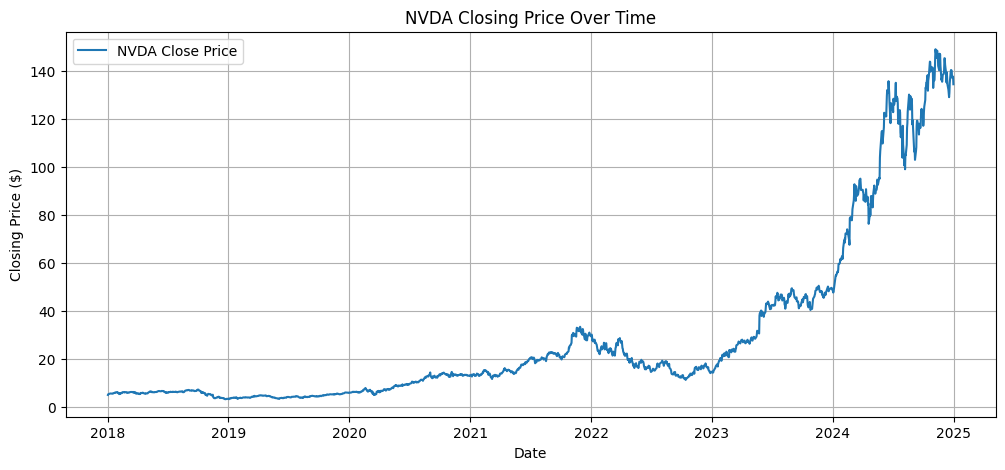

In [65]:
# Plot the closing price over time
plt.figure(figsize=(12, 5))
plt.plot(df['Date'], df['Close'], label='NVDA Close Price')
plt.xlabel('Date')
plt.ylabel('Closing Price ($)')
plt.title('NVDA Closing Price Over Time')
plt.legend()
plt.grid(True)
plt.show()

NVDA's closing price shows a clear upward trend over time, meaning the stock has grown a lot during this period. There are also times when the price moves up and down a lot, which could be due to market uncertainty or events specific to the company. Overall, the rising trend suggests that NVDA might be a good long-term investment, but we should keep in mind the short-term ups and downs.

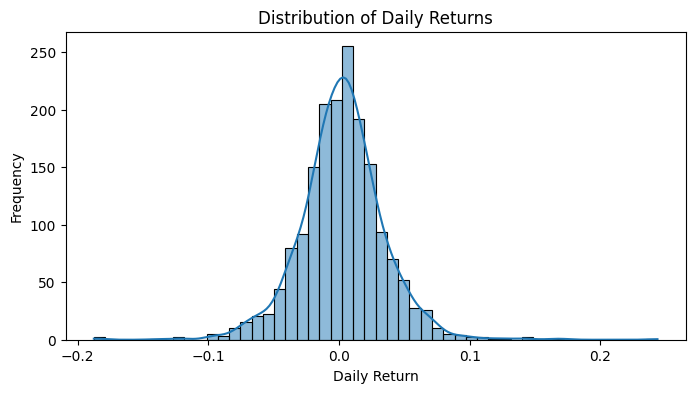

In [66]:
# Plot the distribution of daily returns
plt.figure(figsize=(8, 4))
sns.histplot(df['Daily_Return'].dropna(), bins=50, kde=True)
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()

This histogram displays how often different daily percentage changes in NVDA’s closing price occur The distribution is bell-shaped, which means most daily returns are close to the average, with only small changes on most days. There are a few extreme values on both ends, showing that sometimes the stock experiences very large gains or losses.

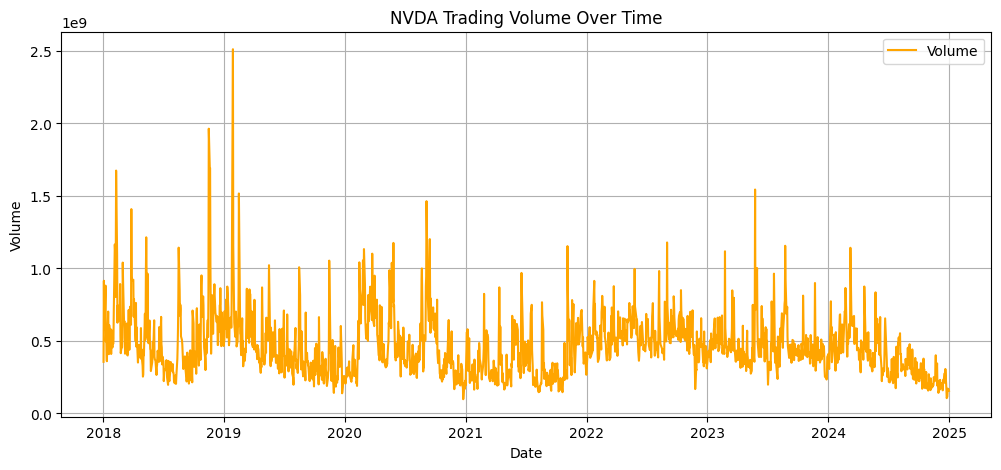

In [67]:
# Plot trading volume over time
plt.figure(figsize=(12, 5))
plt.plot(df['Date'], df['Volume'], color='orange', label='Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('NVDA Trading Volume Over Time')
plt.legend()
plt.grid(True)
plt.show()

This graph shows how many NVDA shares are traded over time. The volume of traded shares fluctuates significantly over time, with some periods of high activity and others with lower activity.

## Data Cleaning and Feature Engineering

**Target Variable Creation:**

The target variable, `Target` is defined as follows:

*   **Target = 1:** If the next day's closing price is higher than today's closing price.
*   **Target = 0:** Otherwise (if the next day's closing price is less than or equal to today's closing price).

**Feature Engineering:**

The following features are engineered:

*   **SMA_10:** A 10-day Simple Moving Average (SMA) of the closing price, calculated using a rolling window.
*   **Price_vs_SMA:** The relative difference between the current closing price and the 10-day SMA. This feature captures how much the current price deviates from its recent trend, as represented by the SMA.


**Data Cleaning:**

*   **Handling Missing Values:** To address missing values introduced by the SMA and daily return calculations, drop the rows containing them. This ensures the dataset is complete for model training.
*   **Dropping Last Row:** The last row of the dataset is dropped, as it does not have a corresponding target value (since we are predicting the next day's movement).

In [68]:
# Create target: 1 if next day's close > today's close, else 0
df['Target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

# Calculate a 10-day simple moving average (SMA)
df['SMA_10'] = df['Close'].rolling(window=10).mean()

# Drop NaN values before further calculations
df.dropna(inplace=True)

# Create a feature for deviation from SMA
df['Price_vs_SMA'] = (df['Close'] - df['SMA_10']) / df['SMA_10'].astype(np.float64)

# Verify 'df' data before display:
print("Dataset shape:", df.shape)

# Display updated dataset
print("\nDataset Information:")
df.head()

Dataset shape: (1752, 10)

Dataset Information:


,Date,Close,High,Low,Open,Volume,Daily_Return,Target,SMA_10,Price_vs_SMA
9,2018-01-16,5.443272,5.626272,5.358696,5.540707,702348000,-0.012871,1,5.380211,0.011721
10,2018-01-17,5.557275,5.567167,5.363889,5.457861,538408000,0.020944,0,5.442950,0.021004
11,2018-01-18,5.550351,5.604756,5.506826,5.537985,408632000,-0.001246,1,5.472552,0.014216
12,2018-01-19,5.690569,5.714804,5.613660,5.640615,609380000,0.025263,1,5.513405,0.032133
13,2018-01-22,5.779102,5.780833,5.640863,5.698483,550944000,0.015558,1,5.558636,0.039662


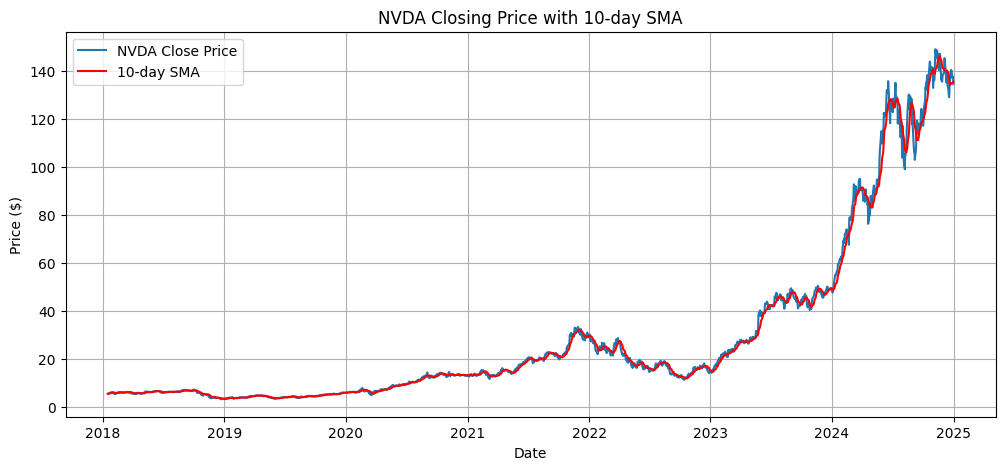

In [69]:
# Plot the closing price and 10-day SMA over time
plt.figure(figsize=(12, 5))
plt.plot(df['Date'], df['Close'], label='NVDA Close Price')
plt.plot(df['Date'], df['SMA_10'], label='10-day SMA', color='red')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title('NVDA Closing Price with 10-day SMA')
plt.legend()
plt.grid(True)
plt.show()

As we can see, the closing price of NVDA stock shows an overall upward trend with periods of significant growth and some periods of decline.
The 10-day SMA generally follows the closing price trend, smoothing out short-term fluctuations.
There are instances where the closing price deviates significantly from the SMA, indicating potential buy or sell signals.

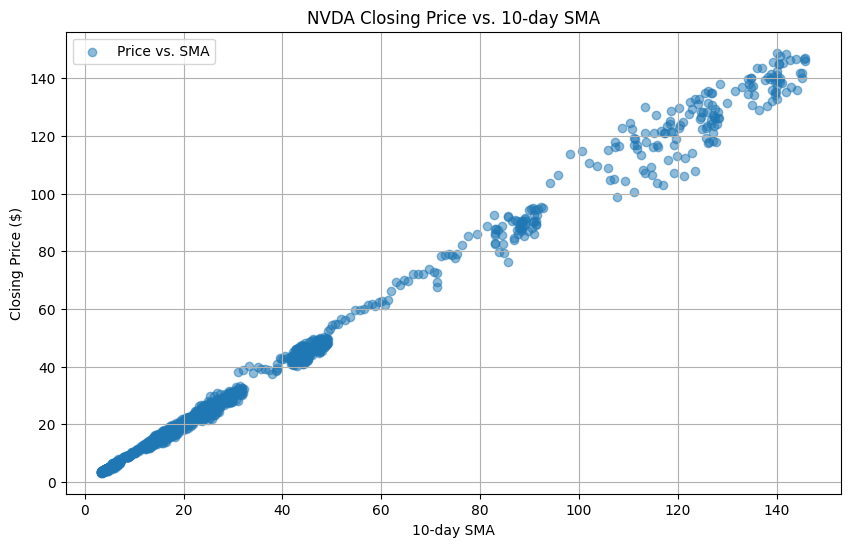

In [70]:
# Plot Price vs. SMA
plt.figure(figsize=(10, 6))
plt.scatter(df['SMA_10'], df['Close'], label='Price vs. SMA', alpha=0.5)  # alpha for transparency
plt.xlabel('10-day SMA')
plt.ylabel('Closing Price ($)')
plt.title('NVDA Closing Price vs. 10-day SMA')
plt.legend()
plt.grid(True)
plt.show()

The scatter plot shows a strong positive linear relationship between the closing price and the 10-day SMA, as expected.
Most of the data points are clustered around the diagonal line, indicating that the closing price often stays close to its moving average.
There are some points scattered away from the diagonal, suggesting instances where the price deviated more significantly from the SMA.

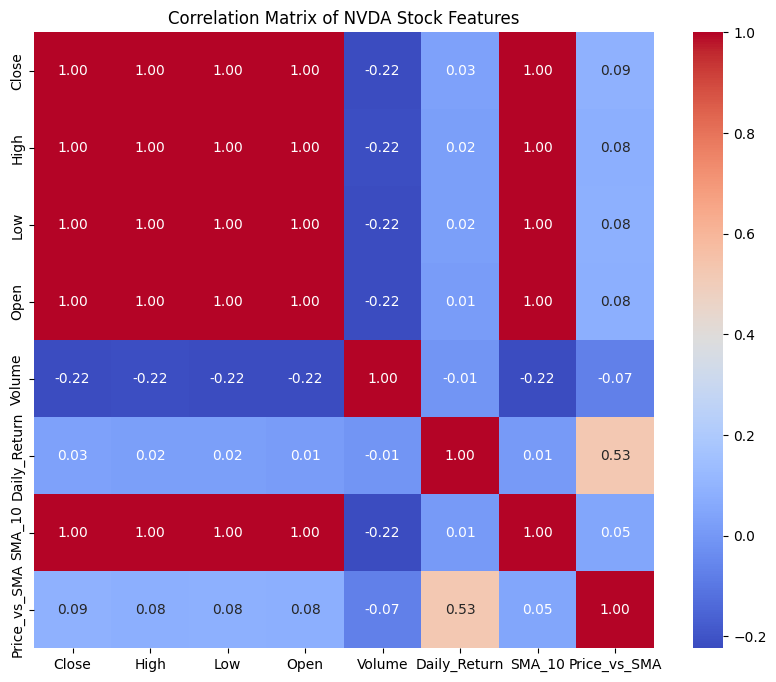

In [71]:
# Calculate the correlation matrix
correlation_matrix = df[['Close', 'High', 'Low', 'Open', 'Volume', 'Daily_Return', 'SMA_10', 'Price_vs_SMA']].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")  # annot=True to display values
plt.title('Correlation Matrix of NVDA Stock Features')
plt.show()

## Observations from the Correlation Matrix

- **High Correlation Among Price Features:**  
  The Open, High, Low, and Close prices are all very highly correlated with each other (above 0.95). This is typical in stock data because these features all come from the same daily price range.

- **Volume Shows Moderate Negative Correlation:**  
  Volume has a moderate negative correlation (around -0.22 to -0.25) with the price features, indicating that as price features increase, trading volume often moves in the opposite direction—or vice versa.

- **Weak Correlation for Daily_Return:**  
  The Daily_Return feature has very low correlations (close to 0) with most other features, suggesting that day-to-day percentage changes don’t closely track the absolute price levels or volume.

- **SMA_10 is Highly Correlated with Close:**  
  Since the 10-day Simple Moving Average is derived from the Close price, it naturally shows a very strong (near 1.0) correlation with Close.

- **Moderate Positive Correlation Between Price_vs_SMA and Daily_Return:**  
  Price_vs_SMA and Daily_Return show a moderate positive correlation (around 0.53). This suggests a potential relationship between how much the price deviates from its recent average and the short-term returns.

# Model Training and Evaluation

## Model Selection

For this task, I chose the following models:

- **Logistic Regression:**  
  Logistic Regression is simple and its coefficients can be easily interpreted, giving insights into the relationship between the features and the target variable. It also serves as a solid baseline for comparing against more complex algorithms.

- **Decision Tree:**  
  Decision Trees can capture non-linear relationships between features and the target, which is valuable for stock market data where trends and patterns are not always linear.

- **Random Forest:**  
  Random Forest is an ensemble method that combines multiple Decision Trees to improve prediction accuracy and reduce overfitting. It is generally robust to outliers and noisy data—conditions often present in financial datasets.

I chose these models to compare different approaches and to understand which one might better capture the complexities of predicting NVDA’s stock price movement.

In [72]:
# Define features (X) and target (y)
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Daily_Return', 'Price_vs_SMA']
X = df[features]
y = df['Target']

In [73]:
# Standardize numerical features using StandardScaler
# This ensures that features with different scales do not influence the model.
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=features, index=X.index)

In [74]:
# Split data into training and test sets
# Shuffle=False is used to maintain the temporal order of the data.
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=False)

In [75]:
# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Store models and their names in a dictionary
models = {
    "Logistic Regression": lr,
    "Decision Tree": dt,
    "Random Forest": rf,
}

results = []

# Iterate through each model, make predictions, and calculate evaluation metrics
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results.append((model_name, acc, prec, rec, f1))

# Convert results to a DataFrame for easier viewing
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-score"])
results_df


,Model,Accuracy,Precision,Recall,F1-score
0,Logistic Regression,0.444444,0.571429,0.020408,0.039409
1,Decision Tree,0.484330,0.546012,0.454082,0.495822
2,Random Forest,0.444444,0.515152,0.086735,0.148472


## Results and Analysis

- **Overall Accuracy:**  
  All models show low accuracy, ranging from about 44% to 48%, which indicates that none are particularly effective at predicting whether NVDA's stock will go up or down.

- **Decision Tree Performance:**  
  Among the three models, the Decision Tree achieves the highest accuracy (48.4%). This suggests it might be a bit better at capturing patterns in the data compared to Logistic Regression and Random Forest.

- **Recall for Class 1 (Up):**  
  The recall for predicting upward movements is very low across all models (ranging from 0.020 to 0.454). This low recall means that the models are missing many days when the stock actually goes up, potentially leading to missed opportunities. The Decision Tree, with a recall of 0.454, performs the best in identifying upward movements.

- **Precision for Class 0 (Down/No Gain):**  
  The precision for class 0 is moderate to high (between 0.44 and 0.615) across most models, indicating that when the models predict a downward or no-gain day, they are often correct.

- **F1-Score for Class 1 (Up):**  
  F1-scores for the "Up" class remain consistently low across models, which reflects the difficulty in balancing precision and recall for upward movements. The Decision Tree has the highest F1-score (0.496) for class 1 among the models, suggesting it may be relatively better at capturing upward trends.

**Overall Conclusion:**  
Despite the Decision Tree showing some promise with higher recall and F1-score for upward movements, all models struggle with the task. The overall low accuracy highlights the inherent difficulty in predicting NVDA's stock price direction based solely on historical price data and basic technical indicators.

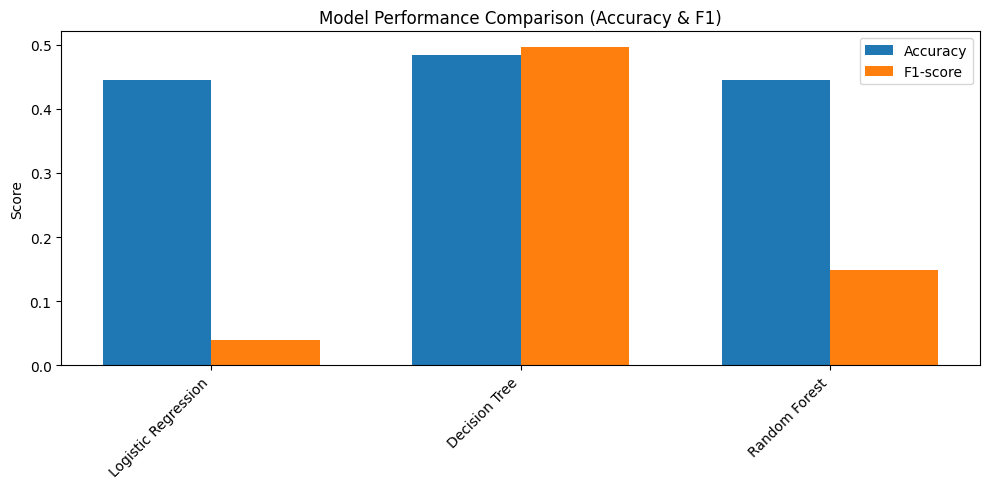

In [76]:
# Model Performance Comparison (Accuracy & F1-score)
plt.figure(figsize=(10, 5))
x = np.arange(len(results_df))  # each model
width = 0.35

# Create bar plots for Accuracy and F1-score
plt.bar(x - width/2, results_df["Accuracy"], width, label='Accuracy')
plt.bar(x + width/2, results_df["F1-score"], width, label='F1-score')

plt.xticks(x, results_df["Model"], rotation=45, ha="right")
plt.ylabel("Score")
plt.title("Model Performance Comparison (Accuracy & F1)")
plt.legend()
plt.tight_layout()

The bar plot shows that the Decision Tree model performs the best among those we tested for predicting NVDA's stock price movement. However, because all models have relatively low accuracy and F1-scores, there's clearly still room to improve our approach.

# Hyperparameter Tuning for Decision Tree

In [77]:
# Define the hyperparameter grid to search
param_grid_dt = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Use GridSearchCV to find the best hyperparameter combination
grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=5, scoring='accuracy')
grid_dt.fit(X_train, y_train)

# Print the best parameters and cross-validation score
print("Best Parameters for Decision Tree:", grid_dt.best_params_)
print("Best Cross-Validation Score:", grid_dt.best_score_)

Best Parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Cross-Validation Score: 0.5303355363497712


The grid search identified the following as the best hyperparameters for the Decision Tree model:
- **Criterion:** 'gini'
- **Max Depth:** 5
- **Min Samples Leaf:** 1
- **Min Samples Split:** 2

The best cross-validation score achieved with these parameters was 0.5303, which suggests that the model has the potential to reach about 53% accuracy on unseen data.

In [78]:
# Get the best Decision Tree model
best_dt = grid_dt.best_estimator_

# Evaluate the tuned Decision Tree model on the test set
y_pred_best_dt = best_dt.predict(X_test)

# Print the accuracy and classification report for the tuned model
print("\nTuned Decision Tree Accuracy:", accuracy_score(y_test, y_pred_best_dt))
print("\nTuned Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_best_dt))


Tuned Decision Tree Accuracy: 0.4672364672364672

Tuned Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.55      0.48       155
           1       0.53      0.40      0.45       196

    accuracy                           0.47       351
   macro avg       0.48      0.48      0.47       351
weighted avg       0.48      0.47      0.47       351



The tuned Decision Tree model achieved an accuracy of 0.4672 on the test set, which is actually a bit lower than the untuned Decision Tree’s accuracy of about 0.4843. However, tuning did affect the balance between precision and recall. For instance, the recall for the "Up" class dropped from around 0.454 in the untuned model to roughly 0.40 in the tuned version. This means that, after tuning, the model correctly identifies upward movements less frequently, even though its overall predictions for both classes are more balanced.

In summary, even with tuning, the model's overall performance remains relatively low—its accuracy is still below the 50% baseline expected for a balanced binary classification problem. This suggests that predicting NVDA’s stock movement is a challenging task with these models.

## Key Takeaways

**Project Objective:**  
In this project, I aimed to predict whether NVDA’s closing price will go up the next day using historical data and technical indicators. I treated this as a binary classification problem.

**Model Insights:**  
- I found that the tuned Decision Tree had slightly better overall accuracy and was a bit more effective at catching upward movements compared to the other models.  
- This suggests that capturing non-linear patterns in the data might be really important.  
- Interestingly, ensemble methods like Random Forest didn’t significantly outperform the tuned Decision Tree, which was a bit unexpected.

**Challenges:**  
- **Market Volatility:** Stock prices are very unpredictable, making accurate predictions really difficult.  
- **Limited Features:** The features I used might not capture all the factors affecting NVDA’s stock movement.  
- **Class Imbalance:** There were fewer upward movement days, which may have made it harder for the models to detect those events.

**Future Improvements:**  
- **Expand Features:** I could rserach and add more technical indicators and fundamental data to better capture market dynamics.  
- **Address Imbalance:** Using techniques like oversampling or undersampling might help balance the classes.  
- **Explore New Models:** It might be worthwhile to try models such as SVMs that could capture complex patterns more effectively.  
- **Ensemble Methods:** I could also experiment with combining different models using AdaBoost to improve overall accuracy.
- **Time Series Models:** Since stock data is inherently sequential, exploring time series models like ARIMA could provide additional insights and potentially improve predictions.

**Overall Conclusion:**  
While the tuned Decision Tree shows some promise, I learned that predicting NVDA's stock movement is quite challenging. There’s definitely room for improvement by expanding the feature set, addressing class imbalance, and exploring alternative modeling approaches.